In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import dotenv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from isrobust_TFG.utils import set_all_seeds

project_path = Path(dotenv.find_dotenv()).parent
data_path = project_path.joinpath("data")

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

2025-02-17 09:44:39.813281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739785479.826301 2110926 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739785479.830207 2110926 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 09:44:39.845867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
config = dotenv.dotenv_values()

stop = float(0.65)
start = float(0.05)
step = float(0.2)

In [29]:
frac_list = np.arange(start, stop, step)

In [30]:
results_path = Path(config["RESULTS_FOLDER"]).resolve()
figs_path = results_path.joinpath("figs")
tables_path = results_path.joinpath("tables")

In [31]:
results_path

PosixPath('/home/sfernandez/TFG/robustness_informed_TFG/path')

In [32]:
models = ["ivae_kegg", "ivae_reactome"] + [
    f"ivae_random-{frac}" for frac in frac_list
]
models

['ivae_kegg',
 'ivae_reactome',
 'ivae_random-0.05',
 'ivae_random-0.25',
 'ivae_random-0.45']

In [33]:
# Metrics

metric_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_metrics.pkl")) for m in models
]
metric_scores = pd.concat(metric_scores, axis=0, ignore_index=True)
metric_scores = metric_scores
metric_scores.head()

,seed,metric,split,score,model
0,0,loss,train,8.289695,ivae_kegg
1,0,mse,train,0.000399,ivae_kegg
2,0,loss,val,8.241375,ivae_kegg
3,0,mse,val,0.000397,ivae_kegg
4,0,loss,test,8.273416,ivae_kegg


In [35]:
models

['ivae_kegg',
 'ivae_reactome',
 'ivae_random-0.05',
 'ivae_random-0.25',
 'ivae_random-0.45']

In [40]:
clustering_scores = [
    pd.read_pickle(results_path.joinpath('ivae_random-0.05', "scores_clustering.pkl"))
]

In [41]:
clustering_scores

[   split  layer     score             model
 0  train      1  0.730876  ivae_random-0.05
 0  train      1  0.585536  ivae_random-0.05
 0  train      1  0.671018  ivae_random-0.05
 1    val      1  0.734369  ivae_random-0.05
 1    val      1  0.589223  ivae_random-0.05
 1    val      1  0.672991  ivae_random-0.05
 2   test      1  0.711058  ivae_random-0.05
 2   test      1  0.590684  ivae_random-0.05
 2   test      1  0.692945  ivae_random-0.05]

In [36]:
# clustering

clustering_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_clustering.pkl")) for m in models
]
clustering_scores = pd.concat(clustering_scores, axis=0, ignore_index=True)
clustering_scores.head()

,split,layer,score,model


In [37]:
clustering_scores

,split,layer,score,model


In [38]:
clustering_scores.groupby(["model", "layer"]).size()

Series([], dtype: int64)

In [39]:
# informed

informed_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_informed.pkl")) for m in models
]
informed_scores = pd.concat(informed_scores, axis=0, ignore_index=True)
informed_scores.head()

,split,layer,score,model


In [25]:
informed_scores.groupby(["model", "layer"]).size()

model            layer
ivae_random-0.1  1        9
dtype: int64

In [26]:
clustering_scores["kind"] = "clustering"
informed_scores["kind"] = "informed"

In [27]:
(metric_scores
 .query("metric=='mse'")
 .drop(["seed"], axis=1)
 .groupby(["model", "metric", "split"])["score"]
 .describe()
 .drop(["count", "min", "max"], axis=1)
 .to_latex(
   "mse.tex",
    bold_rows=True,
    escape=True,
))

In [28]:
metric_scores_to_plot = metric_scores.copy().query("split=='test'").query("metric=='mse'").rename(columns={"model": "Modelo", "score":"Valor"})
metric_scores_to_plot["Valor"] = -np.log(metric_scores_to_plot["Valor"])

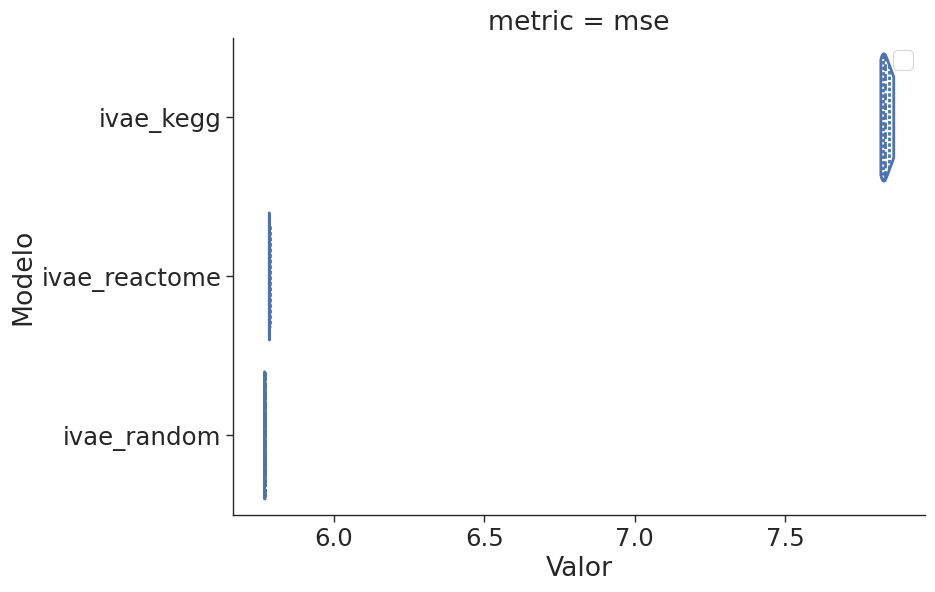

In [29]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.7

g = sns.catplot(
    data=metric_scores_to_plot,
    kind="violin",
    col="metric",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    sharex=False,
    y="Modelo",
    x="Valor",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4,
)

g.savefig("model_mse.pdf")

In [30]:
scores = (
    pd.concat((clustering_scores, informed_scores), axis=0, ignore_index=True)
    .query("split=='test'")
    .query("layer <= 2")
    .drop(["split"], axis=1)
    .rename(columns={"kind": "metric"})
)

scores.head()

,layer,score,model,metric
6,1,0.528596,ivae_random-0.1,clustering
7,1,0.517018,ivae_random-0.1,clustering
8,1,0.626757,ivae_random-0.1,clustering
12,1,0.066683,ivae_random-0.1,informed
13,1,0.017120,ivae_random-0.1,informed


In [31]:
scores_to_plot = scores.copy()
scores_to_plot["layer_name"] = "Pathways"

scores_to_plot = scores_to_plot.replace("clustering", "AMI")
scores_to_plot = scores_to_plot.replace("informed", r"$\tau$")

mask = (scores_to_plot["layer"] == 1) & (scores_to_plot["model"] == "ivae_kegg")
scores_to_plot.loc[mask, "layer_name"] = "Circuitos"

mask = (scores_to_plot["layer"] == 1) & (scores_to_plot["model"] == "ivae_random")
scores_to_plot.loc[mask, "layer_name"] = "RndInf"

scores_to_plot["Modelo"] = scores_to_plot["model"] + " (" + scores_to_plot["layer_name"] + ")"

scores_to_plot = scores_to_plot.rename(columns={"score": "Valor", "metric": "Métrica"})
scores_to_plot.head()

,layer,Valor,model,Métrica,layer_name,Modelo
6,1,0.528596,ivae_random-0.1,AMI,Pathways,ivae_random-0.1 (Pathways)
7,1,0.517018,ivae_random-0.1,AMI,Pathways,ivae_random-0.1 (Pathways)
8,1,0.626757,ivae_random-0.1,AMI,Pathways,ivae_random-0.1 (Pathways)
12,1,0.066683,ivae_random-0.1,$\tau$,Pathways,ivae_random-0.1 (Pathways)
13,1,0.017120,ivae_random-0.1,$\tau$,Pathways,ivae_random-0.1 (Pathways)


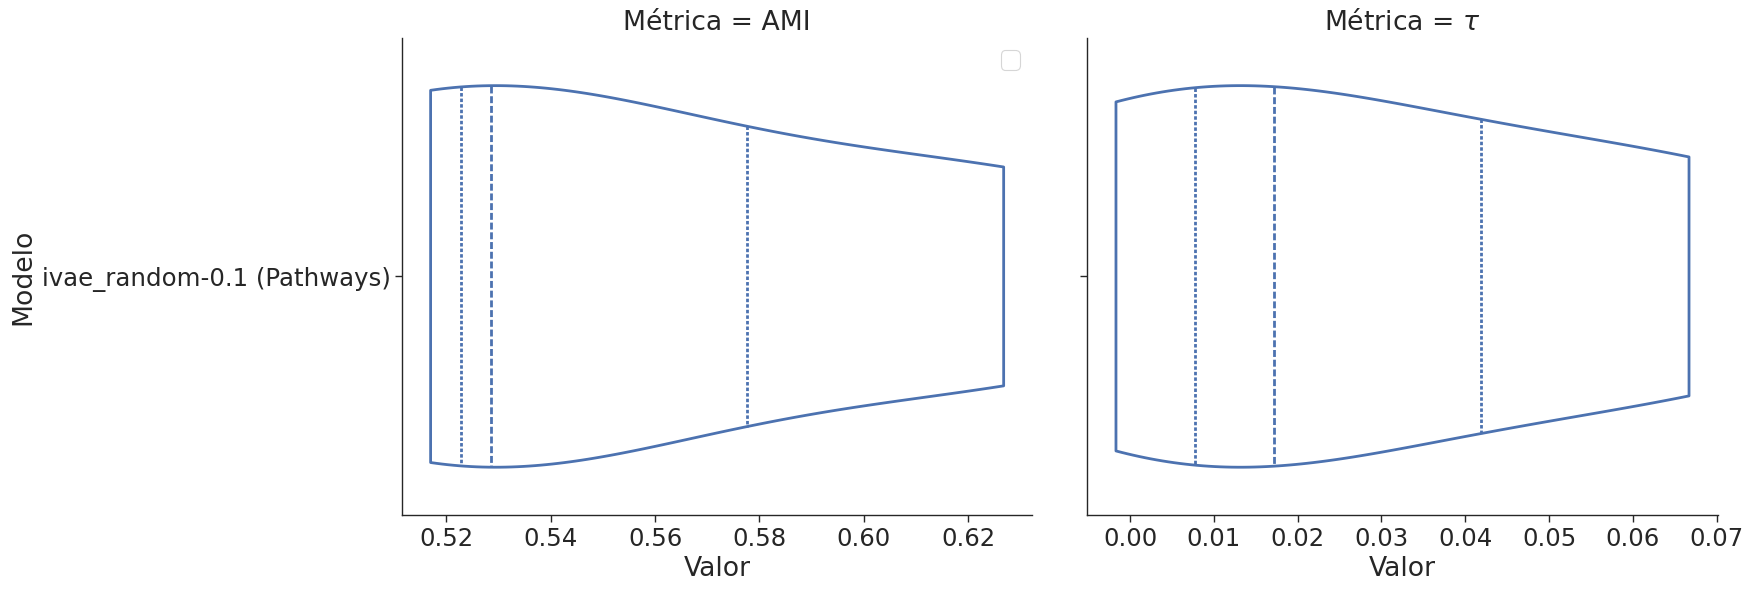

In [32]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.7

g = sns.catplot(
    data=scores_to_plot,
    kind="violin",
    col="Métrica",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    sharex=False,
    y="Modelo",
    x="Valor",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4,
)

g.savefig("layer_scores.pdf")

In [33]:
def print_scores(df, fname):
  df_to_print = df.copy().query("layer <= 2")

  df_to_print["Capa"] = "Pathways"

  mask = (df_to_print["layer"] == 1) & (df_to_print["model"] == "ivae_kegg")
  df_to_print.loc[mask, "Capa"] = "Circuitos"

  mask = (df_to_print["layer"] == 1) & (df_to_print["model"] == "ivae_random")
  df_to_print.loc[mask, "Capa"] = "RndInf"

  (df_to_print
  .rename(columns={"model": "Modelo", "split": "Partición"})
  .groupby(["Modelo", "Capa", "Partición"])["score"]
  .describe().drop(["count", "min", "max"], axis=1)
  .to_latex(
      fname,
      bold_rows=True,
      escape=True,
  ))

In [34]:
print_scores(informed_scores, "informed.tex")
print_scores(clustering_scores, "clustering.tex")
